# 風格轉換(Neural Style Transfer)
### 程式修改自[TF2 Neural style transfer](https://www.tensorflow.org/tutorials/generative/style_transfer)

## 載入相關套件

In [1]:
# 載入相關套件
import os
import time
import sys
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

## 載入內容圖檔

In [2]:
from google.colab import files
files.upload();

Saving chicago.jpg to chicago.jpg
Saving wave.jpg to wave.jpg


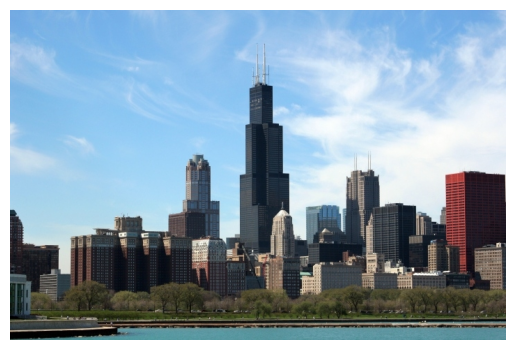

In [3]:
# 載入內容圖檔
content_path = "./chicago.jpg"
content_image = load_img(content_path)
plt.imshow(content_image)
plt.axis('off')
plt.show()

## 載入風格圖檔

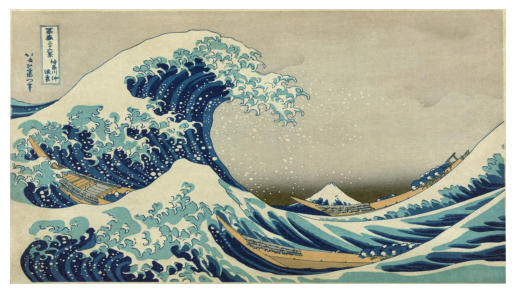

In [4]:
# 載入風格圖檔
style_path = "./wave.jpg"
style_image = load_img(style_path)
plt.imshow(style_image)
plt.axis('off')
plt.show()

## 定義載入圖像並進行前置處理的函數

In [5]:
# 載入圖像並進行前置處理
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    # print(img.shape)

    # 回傳影像陣列
    return img

## 定義由陣列還原圖像的函數

In [6]:
# 由陣列還原圖像
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)

    # 前置處理的還原
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    # 裁切元素值在(0, 255)之間
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## 定義內容圖及風格圖輸出的神經層名稱

In [7]:
# 定義內容圖輸出的神經層名稱
content_layers = ['block5_conv2']

# 定義風格圖輸出的神經層名稱
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## 定義模型：VGG19 + 自訂的輸出

In [8]:
def get_model():
    # 載入 VGG19，不含辨識層
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False  # 不重新訓練
    # for layer in vgg.layers:
    #     layer.trainable = False

    # 以之前定義的內容圖及風格圖神經層為輸出
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs

    # 建立模型
    return tf.keras.Model(vgg.input, model_outputs)

In [9]:
# 內容損失函數
def get_content_loss(base_content, target):
    # 下面可附加 『/ (4. * (channels ** 2) * (width * height) ** 2)』
    return tf.reduce_mean(tf.square(base_content - target))

In [10]:
# 計算 Gram Matrix 函數
def gram_matrix(input_tensor):
    # We make the image channels first
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# 風格損失函數
def get_style_loss(base_style, gram_target):
    # 取得風格圖的高、寬、色彩數
    height, width, channels = base_style.get_shape().as_list()

    # 計算 Gram Matrix
    gram_style = gram_matrix(base_style)

    # 計算風格損失
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [11]:
# 計算內容圖及風格圖的特徵向量
def get_feature_representations(model, content_path, style_path):
    # 載入圖檔
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # 設定模型
    style_outputs = model(style_image)
    content_outputs = model(content_image)


    # 取得特徵向量
    style_features = [style_layer[0] for style_layer
                      in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer
                        in content_outputs[num_style_layers:]]
    return style_features, content_features

In [12]:
# 計算梯度
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        # 累計損失
        all_loss = compute_loss(**cfg)

    # 取得梯度
    total_loss = all_loss[0]
    # cfg['init_image']：內容圖影像陣列
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [13]:
# 計算所有層的損失
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    # 內容圖及風格圖的權重比例
    style_weight, content_weight = loss_weights

    # 取得模型輸出
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    # 累計風格分數
    style_score = 0
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    # 累計內容分數
    content_score = 0
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

    # 乘以權重比例
    style_score *= style_weight
    content_score *= content_weight

    # 總損失
    loss = style_score + content_score

    return loss, style_score, content_score

In [14]:
# 執行訓練的函數
import IPython.display

def run_style_transfer(content_path, style_path, num_iterations=500,
                         content_weight=1e3, style_weight=1e-2):
    # 取得模型
    # model = get_model()

    # 取得內容圖及風格圖的神經層輸出
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # 載入內容圖
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)

    # 指定優化器
    opt = tf.optimizers.Adam(learning_rate=5.0, beta_1=0.99, epsilon=1e-1)

    # 初始化變數
    iter_count = 1
    best_loss, best_img = float('inf'), None
    loss_weights = (style_weight, content_weight)
    cfg = {  # 組態
            'model': model,
            'loss_weights': loss_weights,
            'init_image': init_image,
            'gram_style_features': gram_style_features,
            'content_features': content_features
    }

    # 參數設定
    num_rows = 2  # 輸出小圖以 2 列顯示
    num_cols = 5  # 輸出小圖以 5 行顯示
    # 每N個週期數生成圖像，計算 N：display_interval
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()    # 計時
    global_start = time.time()

    # RGB 三色中心值，輸入圖像以中心值為 0 作轉換
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    # 開始訓練
    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time()

        # 記錄最小損失時的圖像
        if loss < best_loss:
            best_loss = loss   # 記錄最小損失
            best_img = deprocess_img(init_image.numpy()) # 生成圖像

        # 每N個週期數生成圖像
        if i % display_interval== 0:
            start_time = time.time()

            # 生成圖像
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)

            # IPython.display.clear_output(wait=True)  # 可清除之前的顯示
            print(f'週期數: {i}')
            elapsed_time = time.time() - start_time
            print(f'總損失: {loss:.2e}, 風格損失: {style_score:.2e},' +
                        f'內容損失: {content_score:.2e}, 耗時: {elapsed_time:.2f}s')
            IPython.display.display_png(Image.fromarray(plot_img))

    print(f'總耗時: {(time.time() - global_start):.2f}s')
    # IPython.display.clear_output(wait=True)  # 可清除之前的顯示
    # 顯示生成的圖像
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
            plt.subplot(num_rows,num_cols,i+1)
            plt.imshow(img)
            plt.axis('off')

    return best_img, best_loss

## 執行訓練

In [15]:
# 執行訓練
model = get_model()
best, best_loss = run_style_transfer(content_path,
                                 style_path, num_iterations=500)

Output hidden; open in https://colab.research.google.com to view.

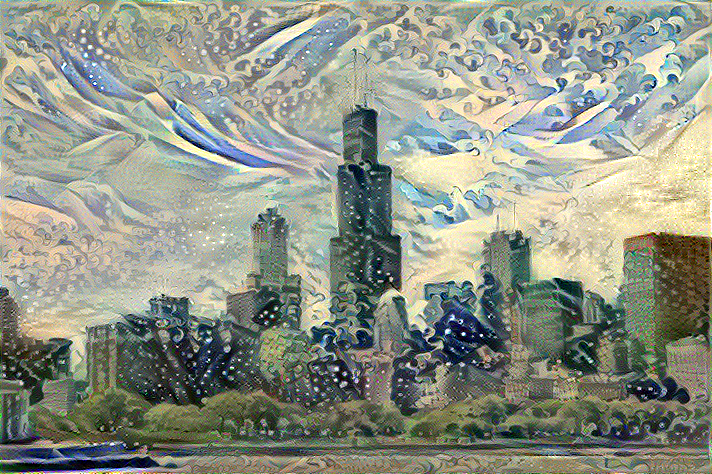

In [ ]:
# 顯示最佳的圖像
Image.fromarray(best)

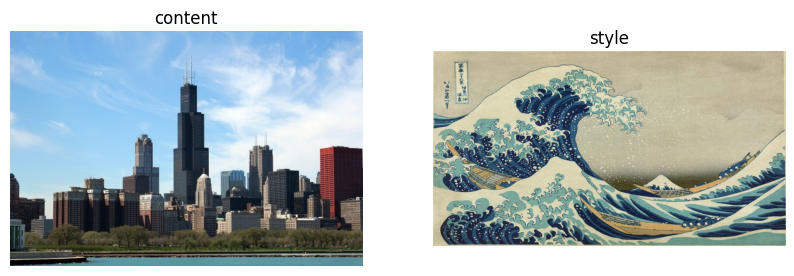

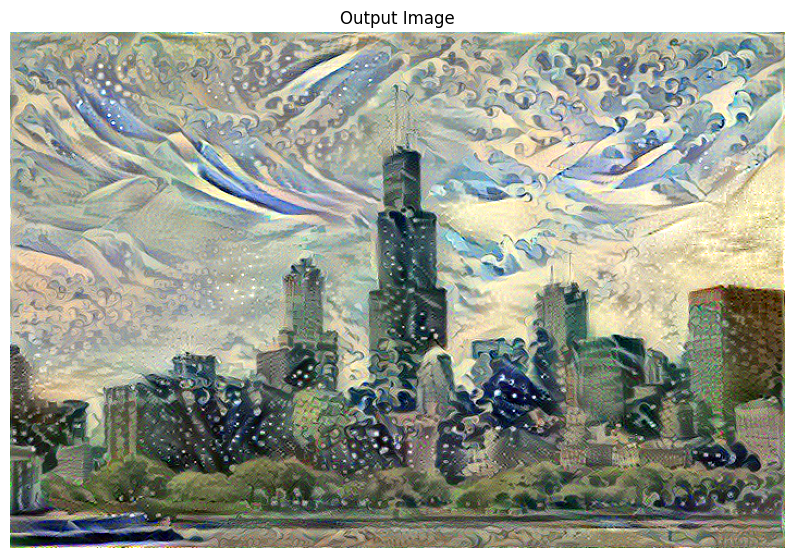

In [ ]:
# 定義顯示函數，比較原圖與生成圖像
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path)
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(content)
    plt.title('content')

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(style)
    plt.title('style')

    if show_large_final:
        plt.figure(figsize=(10, 10))
        plt.axis('off')

        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

# 原圖與生成圖像的比較
show_results(best, content_path, style_path)